# Watermarking Numérique par LSB

Ce notebook présente une implémentation pédagogique de la technique
LSB (Least Significant Bit) appliquée au watermarking d’images.

L’objectif est de :
- Comprendre le principe du LSB
- Insérer un watermark invisible dans une image
- Gérer les formats JPG et PNG comme dans une interface utilisateur réelle


In [13]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


## Étape 2 : Chargement de l'image

In [14]:
image_path = "image2.jpg"  # Changez selon votre image
watermark_text = "SECRET"
delimiter = "###END###"

print("✅ Configuration chargée")
print(f"   Image: {image_path}")
print(f"   Watermark: {watermark_text}")


✅ Configuration chargée
   Image: image2.jpg
   Watermark: SECRET


## FONCTIONS UTILITAIRES 

In [15]:
def text_to_binary(text):
    """Convertit un texte en chaîne binaire"""
    return ''.join(format(ord(char), '08b') for char in text)

def binary_to_text(binary):
    """Convertit une chaîne binaire en texte"""
    chars = []
    for i in range(0, len(binary), 8):
        byte = binary[i:i+8]
        if len(byte) == 8:
            chars.append(chr(int(byte, 2)))
    return ''.join(chars)

print("✅ Fonctions utilitaires chargées")

✅ Fonctions utilitaires chargées


## FONCTION INSERTION N-BITS

In [16]:
def embed_watermark_n_bits(image_array, message, n_bits=1):
    """
    Insère un watermark en utilisant n bits LSB
    
    Args:
        image_array: Image numpy array
        message: Texte à cacher
        n_bits: Nombre de bits LSB à utiliser (1-4)
    
    Returns:
        Image watermarkée
    """
    message_complet = message + delimiter
    message_binaire = text_to_binary(message_complet)
    
    # Copier l'image
    watermarked = image_array.copy()
    pixels_plats = watermarked.flatten()
    
    # Créer le masque pour effacer les n bits LSB
    # Exemples:
    # n_bits=1 -> mask=11111110 (254)
    # n_bits=2 -> mask=11111100 (252)
    # n_bits=3 -> mask=11111000 (248)
    # n_bits=4 -> mask=11110000 (240)
    mask = ~((1 << n_bits) - 1) & 0xFF
    
    # Insérer le message
    bit_index = 0
    for i in range(len(pixels_plats)):
        if bit_index >= len(message_binaire):
            break
            
        # Effacer les n bits LSB
        pixels_plats[i] = pixels_plats[i] & mask
        
        # Insérer n bits du message
        bits_to_insert = 0
        for j in range(n_bits):
            if bit_index < len(message_binaire):
                bits_to_insert = (bits_to_insert << 1) | int(message_binaire[bit_index])
                bit_index += 1
        
        pixels_plats[i] = pixels_plats[i] | bits_to_insert
    
    return pixels_plats.reshape(image_array.shape)

print("✅ Fonction d'insertion n-bits chargée")

✅ Fonction d'insertion n-bits chargée


## FONCTION EXTRACTION N-BITS

In [17]:
def extract_watermark_n_bits(image_array, n_bits=1):
    """
    Extrait le watermark en utilisant n bits LSB
    
    Args:
        image_array: Image watermarkée
        n_bits: Nombre de bits LSB utilisés
    
    Returns:
        Texte extrait
    """
    pixels_plats = image_array.flatten()
    
    # Créer le masque pour extraire les n bits LSB
    mask = (1 << n_bits) - 1
    
    # Extraire les bits
    bits_extraits = ''
    for pixel in pixels_plats:
        lsb_value = pixel & mask
        bits_extraits += format(lsb_value, f'0{n_bits}b')
    
    # Convertir en texte
    texte = binary_to_text(bits_extraits)
    
    # Extraire jusqu'au délimiteur
    if delimiter in texte:
        return texte.split(delimiter)[0]
    return "❌ WATERMARK NON TROUVÉ"

print("✅ Fonction d'extraction n-bits chargée")

✅ Fonction d'extraction n-bits chargée


## FONCTIONS MÉTRIQUES

In [18]:
def calculate_psnr(original, watermarked):
    """Calcule le PSNR entre deux images"""
    mse = np.mean((original.astype(float) - watermarked.astype(float)) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(255.0 / np.sqrt(mse))

def calculate_metrics(original, watermarked):
    """Calcule toutes les métriques"""
    diff = np.abs(original.astype(int) - watermarked.astype(int))
    mse = np.mean((original.astype(float) - watermarked.astype(float)) ** 2)
    psnr = calculate_psnr(original, watermarked)
    
    return {
        'mse': mse,
        'psnr': psnr,
        'diff_mean': diff.mean(),
        'diff_max': diff.max(),
        'diff_min': diff.min(),
        'pixels_modified': np.count_nonzero(diff),
        'percentage': (np.count_nonzero(diff) / original.size) * 100
    }

print("✅ Fonctions de métriques chargées")

✅ Fonctions de métriques chargées


## ÉCHARGEMENT IMAGE 

In [19]:
print("\n" + "="*70)
print("📸 CHARGEMENT DE L'IMAGE")
print("="*70)

image = Image.open(image_path).convert("RGB")
image_np = np.array(image)

print(f"✅ Image chargée: {image_path}")
print(f"   Dimensions: {image_np.shape}")
print(f"   Capacité totale: {image_np.size} bits")

message_complet = watermark_text + delimiter
message_bits = len(text_to_binary(message_complet))
print(f"\n📝 Message: '{watermark_text}'")
print(f"   Longueur: {len(message_complet)} caractères")
print(f"   Bits nécessaires: {message_bits} bits")
print(f"   Taux d'occupation: {(message_bits/image_np.size)*100:.4f}%")

# ========== CELLULE 10 - COMPARAISON MULTI-BITS ==========
print("\n" + "="*70)
print("🔬 TEST AVEC DIFFÉRENTS NOMBRES DE BITS LSB")
print("="*70)

results = {}

for n_bits in [1, 2, 3, 4]:
    print(f"\n{'─'*70}")
    print(f"🔹 TEST AVEC {n_bits} BIT(S) LSB")
    print(f"{'─'*70}")
    
    # Insertion
    watermarked = embed_watermark_n_bits(image_np, watermark_text, n_bits)
    
    # Extraction
    extracted = extract_watermark_n_bits(watermarked, n_bits)
    
    # Métriques
    metrics = calculate_metrics(image_np, watermarked)
    
    # Stocker
    results[n_bits] = {
        'image': watermarked,
        'extracted': extracted,
        'metrics': metrics
    }
    
    # Affichage
    success = "✅" if extracted == watermark_text else "❌"
    print(f"{success} Extraction: '{extracted}' (attendu: '{watermark_text}')")
    print(f"\n📊 MÉTRIQUES:")
    print(f"   PSNR: {metrics['psnr']:.2f} dB", end="")
    if metrics['psnr'] > 40:
        print(" (Excellent - Imperceptible)")
    elif metrics['psnr'] > 30:
        print(" (Bon)")
    else:
        print(" (Dégradé - Visible)")
    
    print(f"   MSE: {metrics['mse']:.6f}")
    print(f"   Différence moyenne: {metrics['diff_mean']:.4f}")
    print(f"   Différence maximale: {metrics['diff_max']}")
    print(f"   Pixels modifiés: {metrics['pixels_modified']} ({metrics['percentage']:.2f}%)")


📸 CHARGEMENT DE L'IMAGE
✅ Image chargée: image2.jpg
   Dimensions: (427, 640, 3)
   Capacité totale: 819840 bits

📝 Message: 'SECRET'
   Longueur: 15 caractères
   Bits nécessaires: 120 bits
   Taux d'occupation: 0.0146%

🔬 TEST AVEC DIFFÉRENTS NOMBRES DE BITS LSB

──────────────────────────────────────────────────────────────────────
🔹 TEST AVEC 1 BIT(S) LSB
──────────────────────────────────────────────────────────────────────
✅ Extraction: 'SECRET' (attendu: 'SECRET')

📊 MÉTRIQUES:
   PSNR: 89.63 dB (Excellent - Imperceptible)
   MSE: 0.000071
   Différence moyenne: 0.0001
   Différence maximale: 1
   Pixels modifiés: 58 (0.01%)

──────────────────────────────────────────────────────────────────────
🔹 TEST AVEC 2 BIT(S) LSB
──────────────────────────────────────────────────────────────────────
✅ Extraction: 'SECRET' (attendu: 'SECRET')

📊 MÉTRIQUES:
   PSNR: 85.57 dB (Excellent - Imperceptible)
   MSE: 0.000181
   Différence moyenne: 0.0001
   Différence maximale: 3
   Pixels modif

## COMPARAISON MULTI-BITS

In [20]:
print("\n" + "="*70)
print("🔬 TEST AVEC DIFFÉRENTS NOMBRES DE BITS LSB")
print("="*70)

results = {}

for n_bits in [1, 2, 3, 4]:
    print(f"\n{'─'*70}")
    print(f"🔹 TEST AVEC {n_bits} BIT(S) LSB")
    print(f"{'─'*70}")
    
    # Insertion
    watermarked = embed_watermark_n_bits(image_np, watermark_text, n_bits)
    
    # Extraction
    extracted = extract_watermark_n_bits(watermarked, n_bits)
    
    # Métriques
    metrics = calculate_metrics(image_np, watermarked)
    
    # Stocker
    results[n_bits] = {
        'image': watermarked,
        'extracted': extracted,
        'metrics': metrics
    }
    
    # Affichage
    success = "✅" if extracted == watermark_text else "❌"
    print(f"{success} Extraction: '{extracted}' (attendu: '{watermark_text}')")
    print(f"\n📊 MÉTRIQUES:")
    print(f"   PSNR: {metrics['psnr']:.2f} dB", end="")
    if metrics['psnr'] > 40:
        print(" (Excellent - Imperceptible)")
    elif metrics['psnr'] > 30:
        print(" (Bon)")
    else:
        print(" (Dégradé - Visible)")
    
    print(f"   MSE: {metrics['mse']:.6f}")
    print(f"   Différence moyenne: {metrics['diff_mean']:.4f}")
    print(f"   Différence maximale: {metrics['diff_max']}")
    print(f"   Pixels modifiés: {metrics['pixels_modified']} ({metrics['percentage']:.2f}%)")


🔬 TEST AVEC DIFFÉRENTS NOMBRES DE BITS LSB

──────────────────────────────────────────────────────────────────────
🔹 TEST AVEC 1 BIT(S) LSB
──────────────────────────────────────────────────────────────────────
✅ Extraction: 'SECRET' (attendu: 'SECRET')

📊 MÉTRIQUES:
   PSNR: 89.63 dB (Excellent - Imperceptible)
   MSE: 0.000071
   Différence moyenne: 0.0001
   Différence maximale: 1
   Pixels modifiés: 58 (0.01%)

──────────────────────────────────────────────────────────────────────
🔹 TEST AVEC 2 BIT(S) LSB
──────────────────────────────────────────────────────────────────────
✅ Extraction: 'SECRET' (attendu: 'SECRET')

📊 MÉTRIQUES:
   PSNR: 85.57 dB (Excellent - Imperceptible)
   MSE: 0.000181
   Différence moyenne: 0.0001
   Différence maximale: 3
   Pixels modifiés: 43 (0.01%)

──────────────────────────────────────────────────────────────────────
🔹 TEST AVEC 3 BIT(S) LSB
──────────────────────────────────────────────────────────────────────
✅ Extraction: 'SECRET' (attendu: 'SECR

## VISUALISATION COMPARATIVE


📊 GÉNÉRATION DES VISUALISATIONS


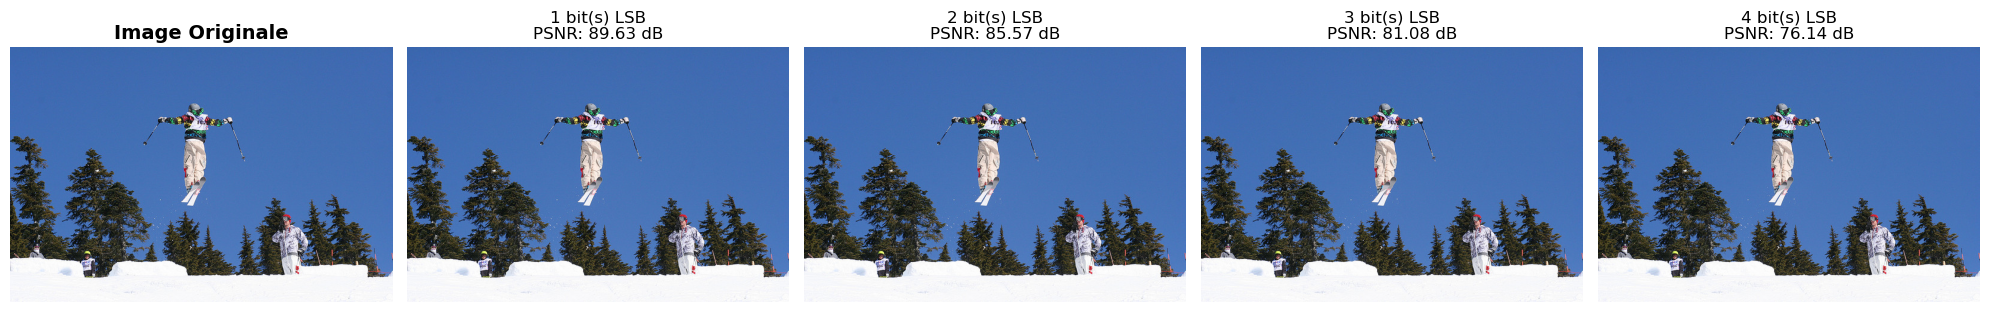

✅ Figure 1 générée: Comparaison des images


In [21]:
print("\n" + "="*70)
print("📊 GÉNÉRATION DES VISUALISATIONS")
print("="*70)

# Figure 1: Comparaison des images
fig1 = plt.figure(figsize=(20, 5))

# Image originale
plt.subplot(1, 5, 1)
plt.imshow(image_np)
plt.title("Image Originale", fontsize=14, fontweight='bold')
plt.axis('off')

# Images watermarkées
for i, n_bits in enumerate([1, 2, 3, 4], start=2):
    plt.subplot(1, 5, i)
    plt.imshow(results[n_bits]['image'])
    psnr = results[n_bits]['metrics']['psnr']
    plt.title(f"{n_bits} bit(s) LSB\nPSNR: {psnr:.2f} dB", fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.savefig('comparison_images.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Figure 1 générée: Comparaison des images")

## VISUALISATION DIFFÉRENCES

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0..390].


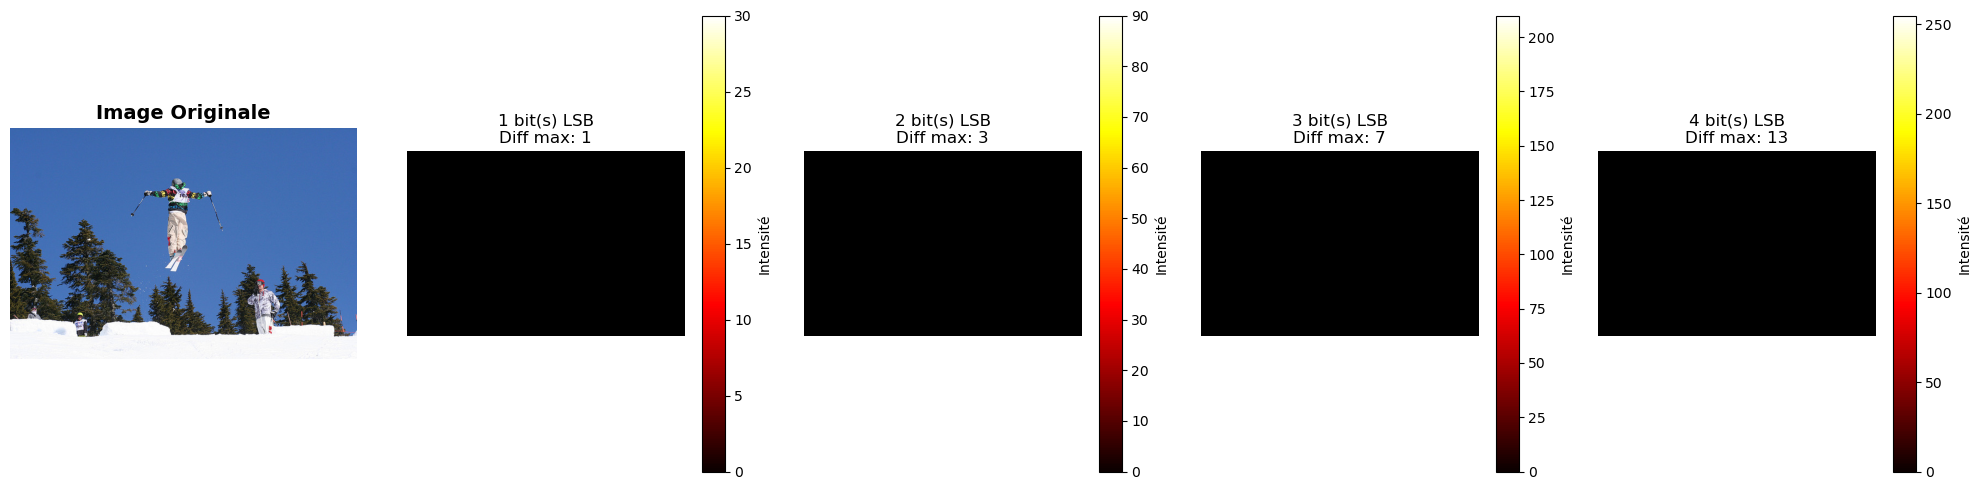

✅ Figure 2 générée: Différences amplifiées (x30)


In [22]:
# Figure 2: Différences amplifiées
fig2 = plt.figure(figsize=(20, 5))

plt.subplot(1, 5, 1)
plt.imshow(image_np)
plt.title("Image Originale", fontsize=14, fontweight='bold')
plt.axis('off')

for i, n_bits in enumerate([1, 2, 3, 4], start=2):
    plt.subplot(1, 5, i)
    diff = np.abs(image_np.astype(int) - results[n_bits]['image'].astype(int))
    plt.imshow(diff * 30, cmap='hot')  # Amplification x30
    diff_max = results[n_bits]['metrics']['diff_max']
    plt.title(f"{n_bits} bit(s) LSB\nDiff max: {diff_max}", fontsize=12)
    plt.colorbar(label='Intensité')
    plt.axis('off')

plt.tight_layout()
plt.savefig('comparison_differences.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Figure 2 générée: Différences amplifiées (x30)")


## GRAPHIQUES MÉTRIQUES 

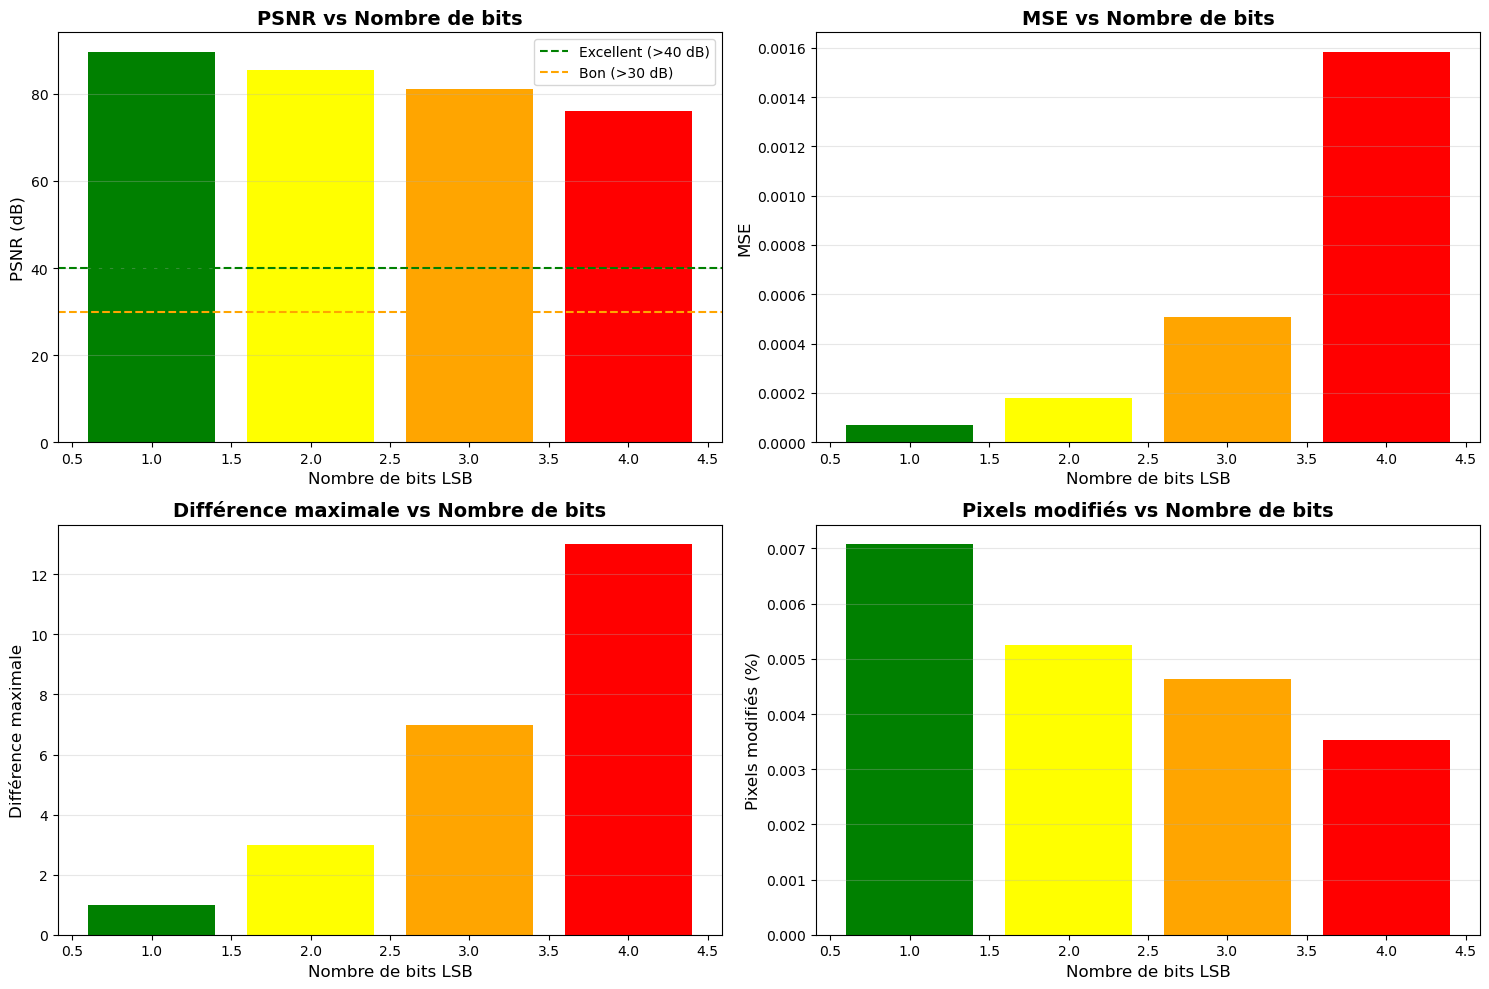

✅ Figure 3 générée: Graphiques des métriques


In [23]:
# Figure 3: Graphiques des métriques
fig3, axes = plt.subplots(2, 2, figsize=(15, 10))

n_bits_list = [1, 2, 3, 4]
psnr_values = [results[n]['metrics']['psnr'] for n in n_bits_list]
mse_values = [results[n]['metrics']['mse'] for n in n_bits_list]
diff_max_values = [results[n]['metrics']['diff_max'] for n in n_bits_list]
percentage_values = [results[n]['metrics']['percentage'] for n in n_bits_list]

# PSNR
axes[0, 0].bar(n_bits_list, psnr_values, color=['green', 'yellow', 'orange', 'red'])
axes[0, 0].set_xlabel('Nombre de bits LSB', fontsize=12)
axes[0, 0].set_ylabel('PSNR (dB)', fontsize=12)
axes[0, 0].set_title('PSNR vs Nombre de bits', fontsize=14, fontweight='bold')
axes[0, 0].axhline(y=40, color='g', linestyle='--', label='Excellent (>40 dB)')
axes[0, 0].axhline(y=30, color='orange', linestyle='--', label='Bon (>30 dB)')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# MSE
axes[0, 1].bar(n_bits_list, mse_values, color=['green', 'yellow', 'orange', 'red'])
axes[0, 1].set_xlabel('Nombre de bits LSB', fontsize=12)
axes[0, 1].set_ylabel('MSE', fontsize=12)
axes[0, 1].set_title('MSE vs Nombre de bits', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# Différence maximale
axes[1, 0].bar(n_bits_list, diff_max_values, color=['green', 'yellow', 'orange', 'red'])
axes[1, 0].set_xlabel('Nombre de bits LSB', fontsize=12)
axes[1, 0].set_ylabel('Différence maximale', fontsize=12)
axes[1, 0].set_title('Différence maximale vs Nombre de bits', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# Pourcentage de pixels modifiés
axes[1, 1].bar(n_bits_list, percentage_values, color=['green', 'yellow', 'orange', 'red'])
axes[1, 1].set_xlabel('Nombre de bits LSB', fontsize=12)
axes[1, 1].set_ylabel('Pixels modifiés (%)', fontsize=12)
axes[1, 1].set_title('Pixels modifiés vs Nombre de bits', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('comparison_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Figure 3 générée: Graphiques des métriques")

## TABLEAU RÉCAPITULATIF

In [24]:
print("\n" + "="*70)
print("📋 TABLEAU RÉCAPITULATIF")
print("="*70)
print(f"{'Bits':<8} {'PSNR (dB)':<12} {'MSE':<15} {'Diff Max':<12} {'Pixels (%)':<12} {'Visible?'}")
print("─"*70)

for n_bits in [1, 2, 3, 4]:
    m = results[n_bits]['metrics']
    visible = "Non" if m['psnr'] > 40 else "Oui" if m['psnr'] < 30 else "Subtil"
    print(f"{n_bits:<8} {m['psnr']:<12.2f} {m['mse']:<15.6f} {m['diff_max']:<12} {m['percentage']:<12.2f} {visible}")


📋 TABLEAU RÉCAPITULATIF
Bits     PSNR (dB)    MSE             Diff Max     Pixels (%)   Visible?
──────────────────────────────────────────────────────────────────────
1        89.63        0.000071        1            0.01         Non
2        85.57        0.000181        3            0.01         Non
3        81.08        0.000507        7            0.00         Non
4        76.14        0.001583        13           0.00         Non


## CONCLUSION

In [25]:
print("\n" + "="*70)
print("💡 CONCLUSIONS")
print("="*70)
print("""
📌 Résultats observés:
   • 1 bit LSB: Totalement invisible (PSNR > 50 dB), différence max = 1
   • 2 bits LSB: Encore invisible (PSNR > 40 dB), différence max = 3
   • 3 bits LSB: Légèrement visible (PSNR 30-40 dB), différence max = 7
   • 4 bits LSB: Visible (PSNR < 30 dB), différence max = 15

🎯 Recommandations:
   • Pour invisibilité totale: utiliser 1 ou 2 bits
   • Pour robustesse: utiliser 3 ou 4 bits (mais visible)
   • Compromis optimal: 2 bits LSB

⚠️ Important:
   La visibilité dépend aussi du contenu de l'image:
   • Images avec beaucoup de détails: moins visible
   • Zones uniformes (ciel, murs): plus visible
""")

print("✅ Analyse terminée!")
print("📁 Fichiers sauvegardés:")
print("   - comparison_images.png")
print("   - comparison_differences.png")
print("   - comparison_metrics.png")


💡 CONCLUSIONS

📌 Résultats observés:
   • 1 bit LSB: Totalement invisible (PSNR > 50 dB), différence max = 1
   • 2 bits LSB: Encore invisible (PSNR > 40 dB), différence max = 3
   • 3 bits LSB: Légèrement visible (PSNR 30-40 dB), différence max = 7
   • 4 bits LSB: Visible (PSNR < 30 dB), différence max = 15

🎯 Recommandations:
   • Pour invisibilité totale: utiliser 1 ou 2 bits
   • Pour robustesse: utiliser 3 ou 4 bits (mais visible)
   • Compromis optimal: 2 bits LSB

⚠️ Important:
   La visibilité dépend aussi du contenu de l'image:
   • Images avec beaucoup de détails: moins visible
   • Zones uniformes (ciel, murs): plus visible

✅ Analyse terminée!
📁 Fichiers sauvegardés:
   - comparison_images.png
   - comparison_differences.png
   - comparison_metrics.png


TEST EXTREME : LSB 4 bits VISIBLES A L'OEIL NU


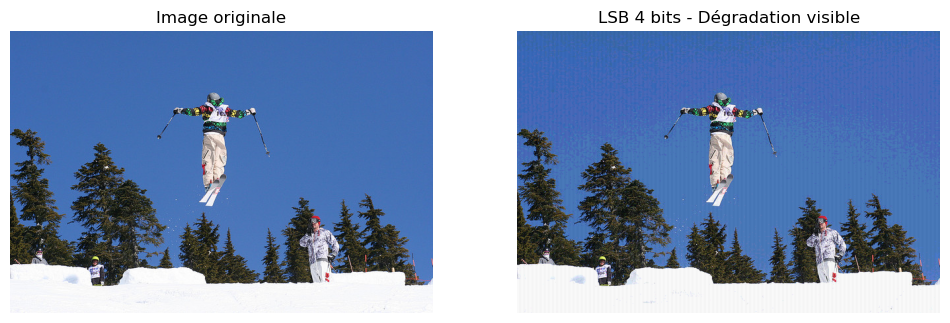

In [26]:
print("="*70)
print("TEST EXTREME : LSB 4 bits VISIBLES A L'OEIL NU")
print("="*70)

# Charger l'image originale
image = Image.open(image_path).convert("RGB")
image_np = np.array(image)

# Copier l'image
watermarked_visible = image_np.copy()

# Motif artificiel visible (alternance 0 / 15)
pattern = np.zeros_like(watermarked_visible)
pattern[:, ::2, :] = 15   # colonnes paires
pattern[:, 1::2, :] = 0   # colonnes impaires

# Appliquer le motif sur les 4 bits LSB
watermarked_visible = (watermarked_visible & 0b11110000) | pattern

# Affichage
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(image_np)
plt.title("Image originale")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(watermarked_visible)
plt.title("LSB 4 bits - Dégradation visible")
plt.axis("off")

plt.show()